In [153]:
import numpy as np
from ripser import ripser
import numpy.random
from numpy.linalg import norm
import matplotlib.pyplot as plt
from persim import plot_diagrams
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

import matplotlib as mpl

In [154]:
def hdr_plot_style():
    plt.style.use('dark_background')
    mpl.rcParams.update({'font.size': 18, 'lines.linewidth': 3, 'lines.markersize': 15})
    # avoid type 3 (i.e. bitmap) fonts in figures
    mpl.rcParams['ps.useafm'] = True
    mpl.rcParams['pdf.use14corefonts'] = True
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = 'Courier New'
    # mpl.rcParams['text.hinting'] = False
    # Set colors cycle
    colors = mpl.cycler('color', ['#3388BB', '#EE6666', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
    #plt.rc('figure', facecolor='#00000000', edgecolor='black')
    #plt.rc('axes', facecolor='#FFFFFF88', edgecolor='white', axisbelow=True, grid=True, prop_cycle=colors)
    plt.rc('legend', facecolor='#666666EE', edgecolor='white', fontsize=16)
    plt.rc('grid', color='white', linestyle='solid')
    plt.rc('text', color='white')
    plt.rc('xtick', direction='out', color='white')
    plt.rc('ytick', direction='out', color='white')
    plt.rc('patch', edgecolor='#E6E6E6')

In [155]:
data =  np.asarray([(numpy.random.normal(), numpy.random.normal()) for i in range(100)])
row_norms = norm(data, axis=1)
circle = data / row_norms[:, None]

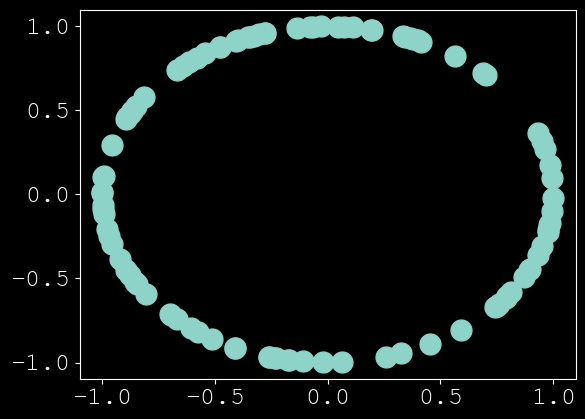

In [156]:
plt.scatter(circle[:, 0], circle[:, 1])

In [157]:
circle_tensor = torch.from_numpy(circle)

In [158]:
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [159]:
def jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian

In [160]:
def score_matching(model, samples, train=False):
    samples.requires_grad_(True)
    logp = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(logp, dim=-1) ** 2 / 2.
    # Compute the Jacobian loss
    jacob_mat = jacobian(model, samples)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
    return (tr_jacobian_loss + norm_loss).mean(-1)

In [161]:
dataset = circle_tensor.float()
for t in range(2000):
    # Compute the loss.
    loss = score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((t % 500) == 0):
        print(loss)

tensor(0.1206, grad_fn=<MeanBackward1>)
tensor(-410.7986, grad_fn=<MeanBackward1>)
tensor(-2010.5153, grad_fn=<MeanBackward1>)
tensor(-3983.4812, grad_fn=<MeanBackward1>)


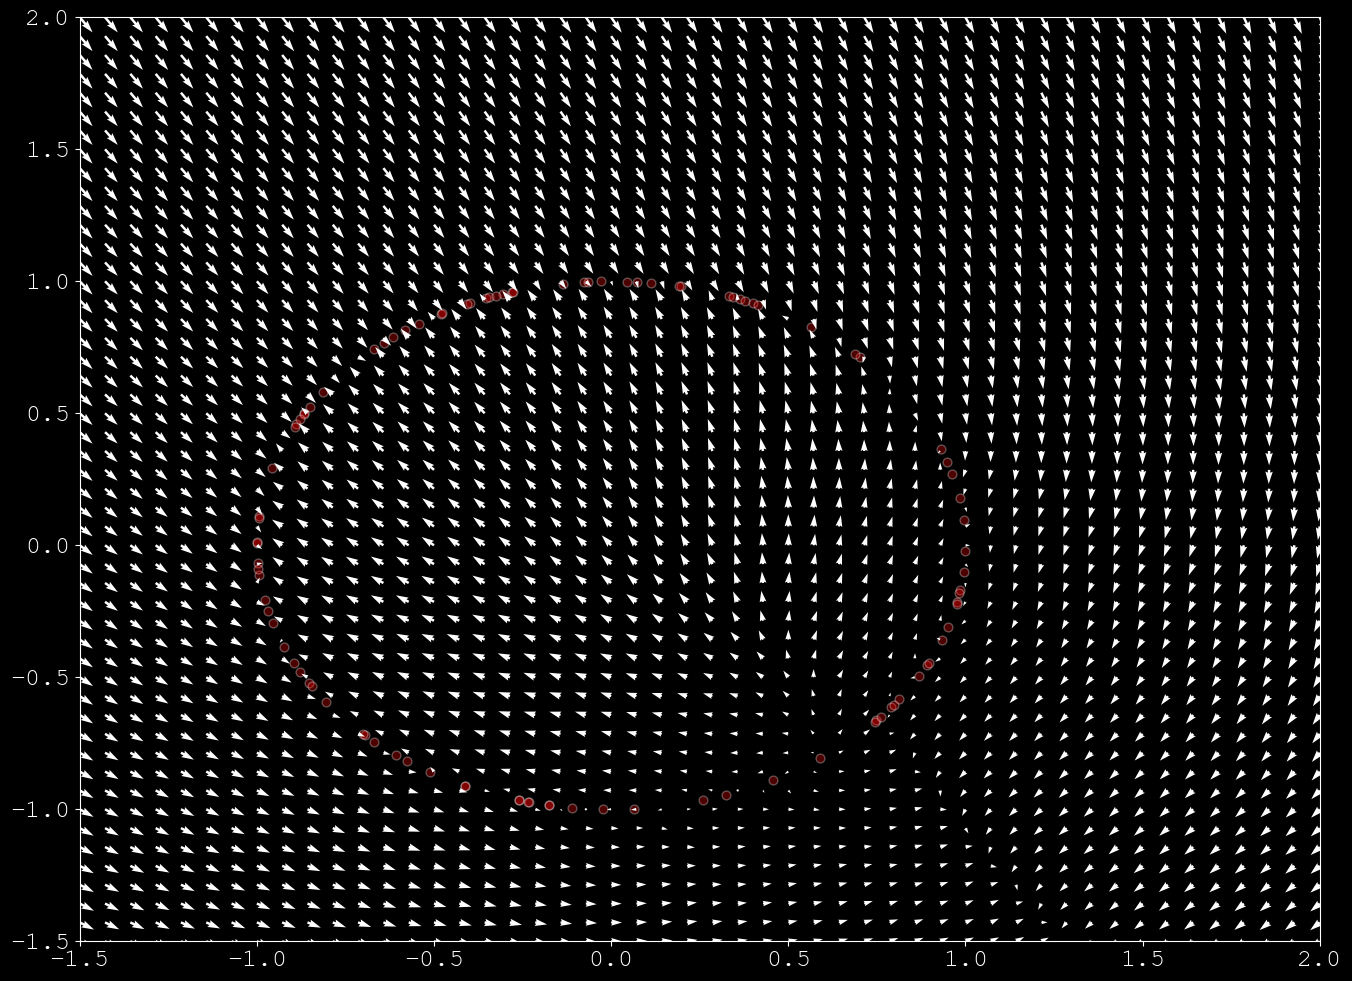

In [162]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.tensor(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
    plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
plot_gradients(model, circle.transpose(-1, 0))

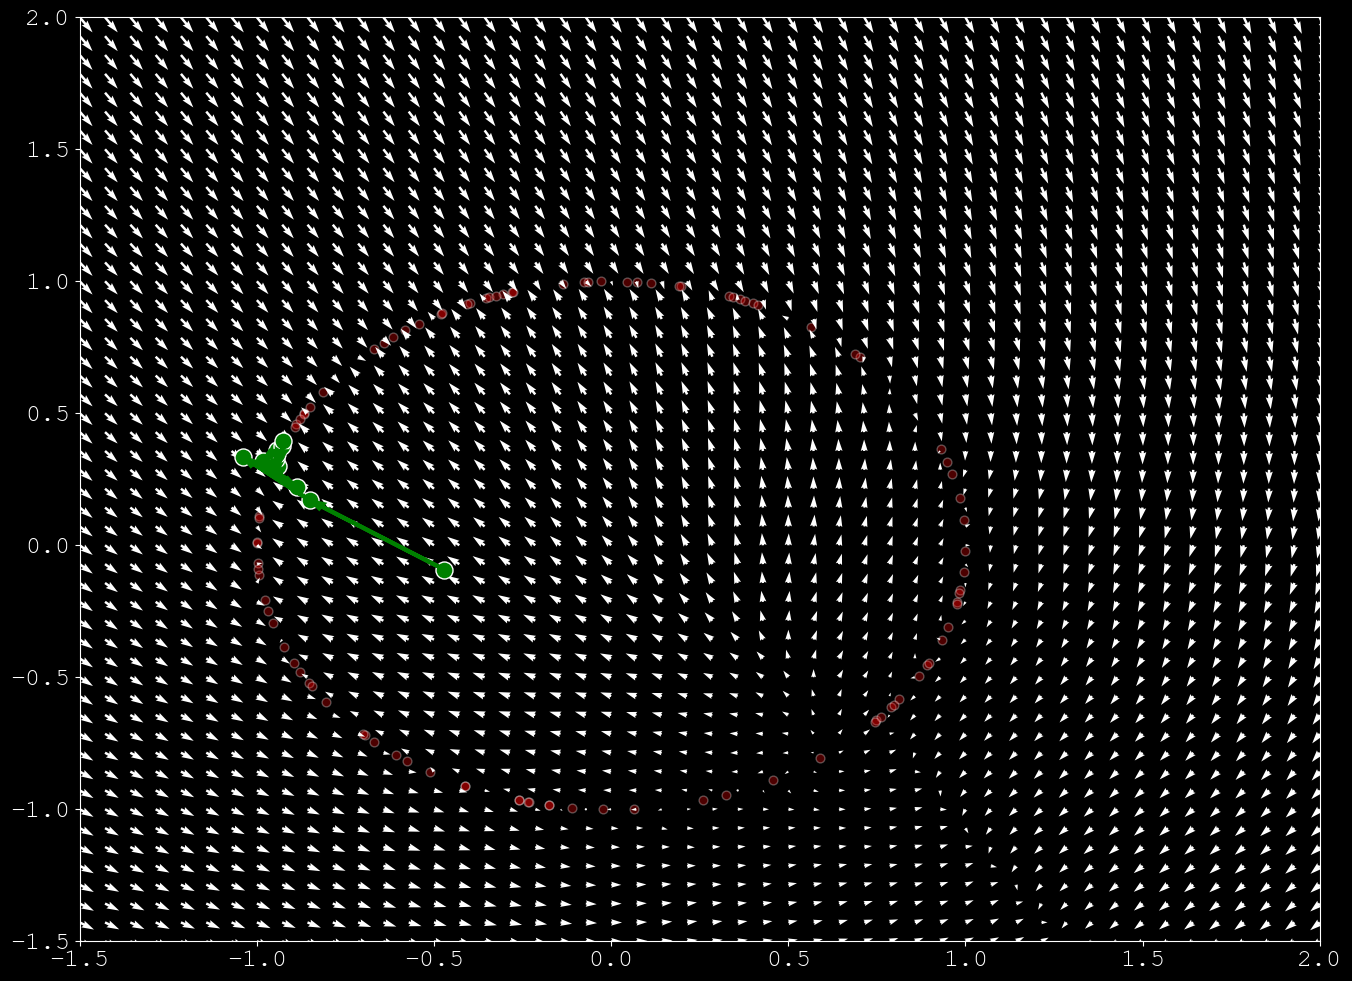

In [163]:
def sample_langevin(model, x=None, n_steps=10, eps=5e-4, decay=.9, temperature=1.0):
    if (x is None):
        x = torch.randn(2)
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        z_t = torch.rand(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    return torch.cat(x_sequence)
def plot_langevin():
    samples = sample_langevin(model).detach()
    plot_gradients(model, dataset.T.detach().numpy())
    plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
    # draw arrows for each mcmc step
    deltas = (samples[1:] - samples[:-1])
    deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)
plot_langevin()

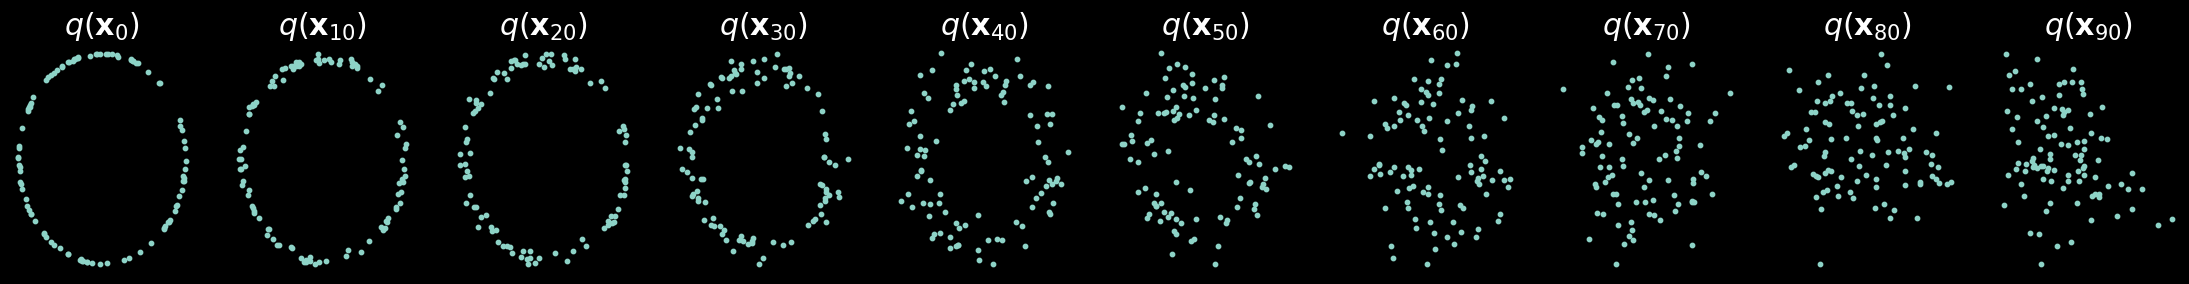

In [164]:
n_steps = 100
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)
# Create schedule
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
# Fixed computation of variables for all timesteps
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
# Sampling function
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)
def plot_diffusion():
    fig, axs = plt.subplots(1, 10, figsize=(28, 3))
    for i in range(10):
        q_i = q_sample(dataset, torch.tensor([i * 10])).detach().numpy()
        axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
        axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')
plot_diffusion()



In [165]:
t = sample_langevin(model)

In [166]:
t[10, :] 

tensor([-0.9906,  0.1242], grad_fn=<SliceBackward0>)

In [167]:
new_circle = torch.stack([sample_langevin(model, x = None)[10, :] for _ in range(100)], dim=0)

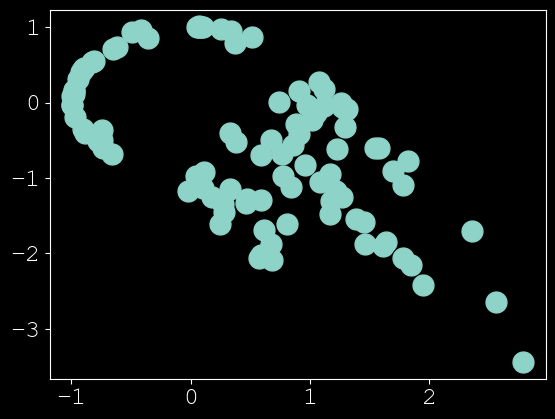

In [168]:
new_circle = new_circle.detach().numpy()
plt.scatter(new_circle[:, 0], new_circle[:, 1])

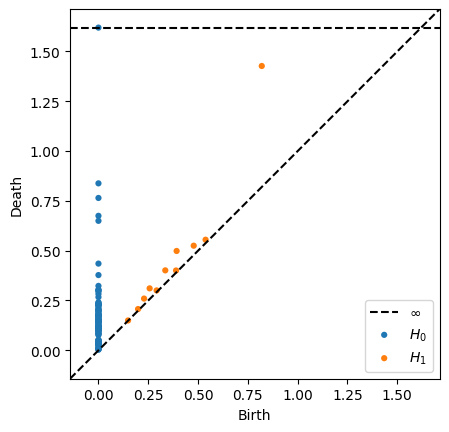

In [172]:
diagrams = ripser(new_circle)['dgms']
plt.style.use("default")
plot_diagrams(diagrams, show=True)